In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
from tensorflow import keras

# DATA PREPARATION

In [2]:
#Read file from csv to pandas DataFrame
dataDf=pd.read_csv("municipality_bus_utilization.csv", na_values = "?")
#Code refactoring
dataset=dataDf.copy()

In [3]:
#Check the dataset
dataset.head(20)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [4]:
#Check for NaN values
dataset.isna().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [5]:
#Convert Datetime data to timestamp in seconds
dataset["timestampSeconds"]=pd.to_datetime(pd.to_datetime(dataset["timestamp"]).dt.strftime('%Y-%m-%d %H:00:00')).map(pd.Timestamp.timestamp).astype(int)
#Make sure that dataset is sorted by timestamp and then municipality_id in the group
dataset=dataset.sort_values(by=["timestampSeconds","municipality_id"])
dataset.reset_index(drop=True, inplace=True)

In [6]:
#Check for logical mistakes
dataset[dataset.usage > dataset.total_capacity]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds
7612,2017-07-17 12:04:02,1,399,397,1500292800
7613,2017-07-17 12:31:03,1,401,397,1500292800
7632,2017-07-17 13:04:03,1,399,397,1500296400
7633,2017-07-17 13:31:03,1,403,397,1500296400
7653,2017-07-17 14:04:03,1,403,397,1500300000
...,...,...,...,...,...
13012,2017-08-19 14:03:31,1,408,397,1503151200
13013,2017-08-19 14:30:33,1,410,397,1503151200
13032,2017-08-19 15:03:34,1,408,397,1503154800
13033,2017-08-19 15:29:33,1,411,397,1503154800


In [7]:
#It seems 229 data exceeds total_capacity that is not possible, so we will change "usage value" of illegal ones as total capacitiy
dataset.loc[dataset.usage > dataset.total_capacity,"usage"]=dataset.loc[dataset.usage > dataset.total_capacity,"total_capacity"]

In [8]:
#Let'check out any strange values inside the data
dataset[dataset.usage < 0]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [9]:
dataset[dataset.total_capacity <= 0]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [10]:
dataset[dataset.municipality_id < 0]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [11]:
dataset[dataset.municipality_id > 9]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [12]:
#Function checks missing rows, if exists, it fills with previous one day (filling with previous strategy).
def anyMissingRows(df):
    checkDf=df.copy()
    firstTimestamp=checkDf.at[0,"timestampSeconds"]
    lastTimestamp=checkDf.at[len(checkDf)-1,"timestampSeconds"]
    timeDifference=3600#1 hour equals to 3600 seconds
    timeDifferenceOneDay=3600*24
    lastTimestamp=lastTimestamp+timeDifference
    for timeStmp in range(firstTimestamp,lastTimestamp,timeDifference):
        numberOfBus=len(checkDf[checkDf.timestampSeconds==timeStmp])
        if(numberOfBus==0):
            #Value is missing in this specific time. We apply that filling missing value with previous but 24 hours before
            fillingData=checkDf[checkDf.timestampSeconds == timeStmp-timeDifferenceOneDay].copy()
            if(len(fillingData)<= 0):#If 1 day before not exists
                fillingData=checkDf[checkDf.timestampSeconds == timeStmp-timeDifference].copy()
            fillingData["timestampSeconds"]=timeStmp
            fillingData["timestamp"]=pd.to_datetime(fillingData["timestampSeconds"],unit="s")
            checkDf=pd.concat([checkDf,fillingData],axis=0)
            checkDf.reset_index(drop=True, inplace=True)
        
    checkDf=checkDf.sort_values(by=["timestampSeconds","municipality_id"])
    checkDf.reset_index(drop=True, inplace=True)

    return checkDf

In [13]:
dataset=anyMissingRows(dataset)

In [14]:
#Now all hourly timestamp includes at least 10 municipalities, we will eliminate 20 buses to 10 buses by choosing max value of eachother.  
dataset

,timestamp,municipality_id,usage,total_capacity,timestampSeconds
0,2017-06-04 07:59:42,0,204,2813,1496559600
1,2017-06-04 07:59:42,1,129,397,1496559600
2,2017-06-04 07:59:42,2,273,697,1496559600
3,2017-06-04 07:59:42,3,623,1930,1496559600
4,2017-06-04 07:59:42,4,1090,3893,1496559600
...,...,...,...,...,...
35735,2017-08-19 16:30:35,7,1354,2019,1503158400
35736,2017-08-19 16:03:35,8,1253,2947,1503158400
35737,2017-08-19 16:30:35,8,1193,2947,1503158400
35738,2017-08-19 16:03:35,9,879,1332,1503158400


In [15]:
#Find the maximum usage in a hour for any municipality_id
def busUsageMax(df):
    checkDf=df.copy()
    busUsageMaxDf=pd.DataFrame(columns=df.columns)
    firstTimestamp=checkDf.at[0,"timestampSeconds"]
    lastTimestamp=checkDf.at[len(checkDf)-1,"timestampSeconds"]
    timeDifference=3600#1 hour equals to 3600 seconds
    lastTimestamp=lastTimestamp+timeDifference
    busNumbers=list(range(0,10))
    for timeStmp in range(firstTimestamp,lastTimestamp,timeDifference):
        tempDf=checkDf[checkDf.timestampSeconds==timeStmp].copy()
        for bus in busNumbers:
            newdf=tempDf[tempDf.municipality_id==bus]
            newdf=newdf[newdf.usage==tempDf.loc[tempDf.municipality_id==bus,"usage"].max()]
            if(len(newdf)>1):#More than one values can be same
                busUsageMaxDf=busUsageMaxDf.append(newdf.iloc[0])
            else:
                busUsageMaxDf=busUsageMaxDf.append(newdf)
        
    busUsageMaxDf=busUsageMaxDf.sort_values(by=["timestampSeconds","municipality_id"])
    busUsageMaxDf.reset_index(drop=True, inplace=True)

    return busUsageMaxDf

In [16]:
#Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour
dataset=busUsageMax(dataset)
dataset

,timestamp,municipality_id,usage,total_capacity,timestampSeconds
0,2017-06-04 07:59:42,0,204,2813,1496559600
1,2017-06-04 07:59:42,1,129,397,1496559600
2,2017-06-04 07:59:42,2,273,697,1496559600
3,2017-06-04 07:59:42,3,623,1930,1496559600
4,2017-06-04 07:59:42,4,1090,3893,1496559600
...,...,...,...,...,...
18335,2017-08-19 16:03:35,5,239,587,1503158400
18336,2017-08-19 16:03:35,6,1727,3113,1503158400
18337,2017-08-19 16:03:35,7,1450,2019,1503158400
18338,2017-08-19 16:03:35,8,1253,2947,1503158400


"The committee asks you to forecast the hourly bus usages for next week for each municipality.",according to this sentence, we need to identify which feature will be useful to predict the hourly bus usages for each municipality.
Therefore, only valuable feature in dataset is "usage" for timeseries. Munipality_id and total_capacity (constant for each municipality) are both categorical and non-beneficial. Actually, we can apply feature engineering for municipality_id by generating 10 features represents binary value, but it takes so much time and effort and I don't know that it will be successful for this dataset.So,for simplicity, we will use only usage. Moreover, we should generate one model for only p-one municipality. Because requirement is independent for each  municipality.
This is an univariate timeseries problem. Hence I will choose one bus to create model. Let's say municipality_id=6. After that, we will do same things specifically and iteratively for other buses. 

In [17]:
selectedMunicipality=6
muniSixthDf=dataset.loc[dataset.municipality_id==selectedMunicipality,["timestampSeconds","usage"]]
muniSixthDf.reset_index(drop=True, inplace=True)
muniSixthDf["usage"]=muniSixthDf["usage"].apply(pd.to_numeric)
muniSixthDf

,timestampSeconds,usage
0,1496559600,597
1,1496563200,801
2,1496566800,1061
3,1496570400,1219
4,1496574000,1297
...,...,...
1829,1503144000,1787
1830,1503147600,1845
1831,1503151200,1853
1832,1503154800,1829


(array([  37.,  103.,   92.,  119., 1247.,  144.,   41.,   18.,   18.,
          15.]),
 array([ 399. ,  551.1,  703.2,  855.3, 1007.4, 1159.5, 1311.6, 1463.7,
        1615.8, 1767.9, 1920. ]),
 <a list of 10 Patch objects>)

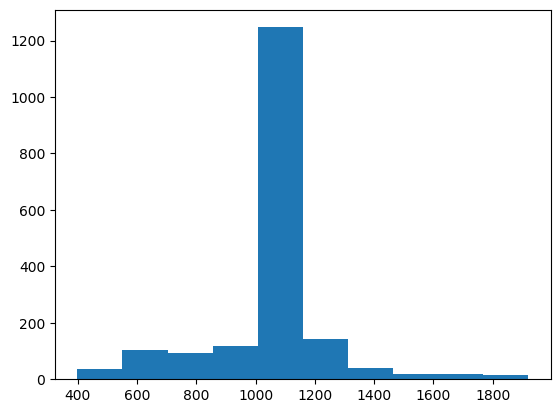

In [18]:
#Dataset shows Gaussian Distribution with 10 bins
plt.hist(np.array(muniSixthDf[["usage"]]),bins=10)

In [19]:
dataStats = muniSixthDf.describe()

dataStats

,usage
count,1834.000000
mean,1025.922028
std,193.035456
min,399.000000
25%,1028.000000
50%,1028.000000
75%,1028.000000
max,1920.000000


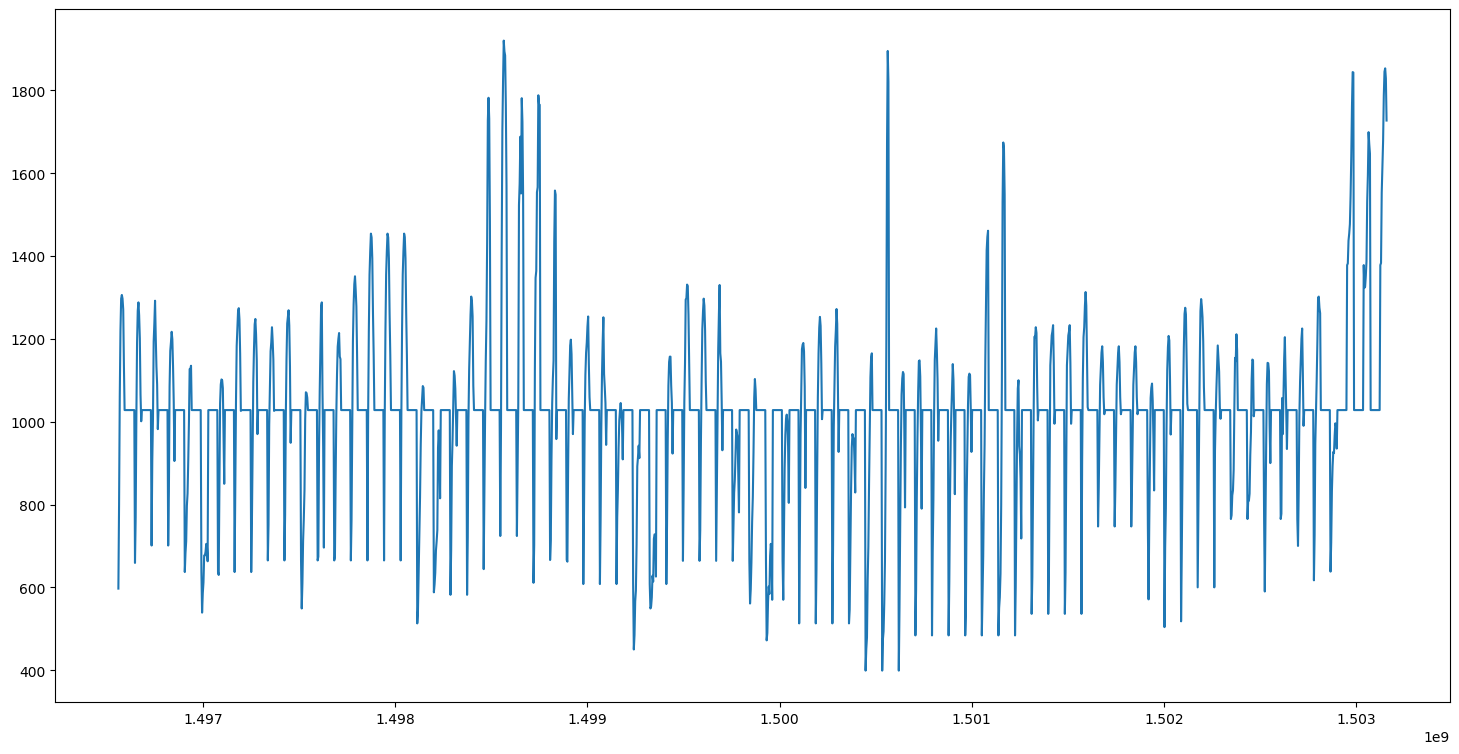

In [20]:
xpoints = np.array(muniSixthDf[["timestampSeconds"]])
ypoints = np.array(muniSixthDf[["usage"]])
plt.figure(figsize=(18, 9))
plt.plot(xpoints, ypoints)
#Data has no seasonality or no trend, but frequent value is 1028 and it is the median, also. It seems that we usually forcast the mean.
                               

One of the most important subject is data partitioning for timeseries problems. The problem wants us to predict the last week. Therefore I will keep the last week as a hold out data, rest of data will be 80% for training and 20% for validation purposes. After we have generated a stable model, we will train our model with both training and validation. Then we will predict the last week which is hold out data.

In [21]:
def prepareWindowedDataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
series=muniSixthDf.pop('usage')
timestampSeries=muniSixthDf.pop('timestampSeconds')
dataset=pd.DataFrame()
dataset['usage']=series.copy()
#dataset=np.array(dataset)
series=np.array(series)  
time = np.array(timestampSeries)

seriesSize=len(series)
holdoutSize=24*7
splitSize=seriesSize-holdoutSize


splitPoint = int(splitSize * 0.80)

timeTrain = time[:splitPoint]
xTrain = series[:splitPoint]
timeValid = time[splitPoint:-holdoutSize]
xValid = series[splitPoint:-holdoutSize]
timeHoldOut = time[-holdoutSize:]
holdOut = series[-holdoutSize:]
woutHOutSeries=series[:-holdoutSize]

keras.backend.clear_session()
tf.random.set_seed(2022)
np.random.seed(2022)

window_size = 168
train_set = prepareWindowedDataset(xTrain, window_size,
                                   batch_size=200)
valid_set = prepareWindowedDataset(xValid, window_size,
                                   batch_size=200)

holdout_set = prepareWindowedDataset(woutHOutSeries, window_size,
                                   batch_size=200)

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 10, 14):#, 32
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=7.5e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
try:
    model = keras.models.load_model("BestModel.h5")
except:
    pass

model_checkpoint = keras.callbacks.ModelCheckpoint("BestModel.h5",
                                                   monitor='loss',
                                                   save_best_only=True, mode='min')

history = model.fit(train_set, epochs=100,verbose=2, 
                    validation_data=valid_set,
                    callbacks=[model_checkpoint])



Epoch 1/100
6/6 - 3s - loss: 49.2814 - mean_absolute_error: 49.7697 - val_loss: 33.1103 - val_mean_absolute_error: 33.5991
Epoch 2/100
6/6 - 2s - loss: 49.2454 - mean_absolute_error: 49.7353 - val_loss: 32.8940 - val_mean_absolute_error: 33.3773
Epoch 3/100
6/6 - 2s - loss: 49.1092 - mean_absolute_error: 49.5979 - val_loss: 32.8912 - val_mean_absolute_error: 33.3781
Epoch 4/100
6/6 - 2s - loss: 49.0494 - mean_absolute_error: 49.5389 - val_loss: 32.8364 - val_mean_absolute_error: 33.3239
Epoch 5/100
6/6 - 2s - loss: 48.9276 - mean_absolute_error: 49.4164 - val_loss: 32.9355 - val_mean_absolute_error: 33.4229
Epoch 6/100
6/6 - 2s - loss: 48.8024 - mean_absolute_error: 49.2911 - val_loss: 32.9482 - val_mean_absolute_error: 33.4364
Epoch 7/100
6/6 - 2s - loss: 48.7341 - mean_absolute_error: 49.2236 - val_loss: 32.8481 - val_mean_absolute_error: 33.3375
Epoch 8/100
6/6 - 2s - loss: 48.7172 - mean_absolute_error: 49.2070 - val_loss: 32.8105 - val_mean_absolute_error: 33.2985
Epoch 9/100
6/6 

Epoch 68/100
6/6 - 2s - loss: 43.4982 - mean_absolute_error: 43.9827 - val_loss: 30.0054 - val_mean_absolute_error: 30.4888
Epoch 69/100
6/6 - 2s - loss: 43.4069 - mean_absolute_error: 43.8912 - val_loss: 29.8013 - val_mean_absolute_error: 30.2810
Epoch 70/100
6/6 - 1s - loss: 43.3400 - mean_absolute_error: 43.8243 - val_loss: 30.1562 - val_mean_absolute_error: 30.6442
Epoch 71/100
6/6 - 2s - loss: 43.2932 - mean_absolute_error: 43.7788 - val_loss: 29.7242 - val_mean_absolute_error: 30.1988
Epoch 72/100
6/6 - 2s - loss: 43.1844 - mean_absolute_error: 43.6686 - val_loss: 29.7098 - val_mean_absolute_error: 30.1934
Epoch 73/100
6/6 - 2s - loss: 43.0982 - mean_absolute_error: 43.5815 - val_loss: 29.7444 - val_mean_absolute_error: 30.2320
Epoch 74/100
6/6 - 1s - loss: 43.0484 - mean_absolute_error: 43.5325 - val_loss: 29.6643 - val_mean_absolute_error: 30.1505
Epoch 75/100
6/6 - 2s - loss: 42.9865 - mean_absolute_error: 43.4702 - val_loss: 29.5612 - val_mean_absolute_error: 30.0438
Epoch 76

In [24]:
#Now we will train the whole data except for "Hold Out" 
model = keras.models.load_model("BestModel.h5")
history = model.fit(holdout_set, epochs=50,verbose=2,
                    callbacks=[model_checkpoint])

Epoch 1/50
8/8 - 2s - loss: 39.7863 - mean_absolute_error: 40.2681
Epoch 2/50
8/8 - 3s - loss: 39.7105 - mean_absolute_error: 40.1925
Epoch 3/50
8/8 - 3s - loss: 39.6532 - mean_absolute_error: 40.1356
Epoch 4/50
8/8 - 3s - loss: 39.5482 - mean_absolute_error: 40.0311
Epoch 5/50
8/8 - 3s - loss: 39.4825 - mean_absolute_error: 39.9648
Epoch 6/50
8/8 - 3s - loss: 39.3970 - mean_absolute_error: 39.8790
Epoch 7/50
8/8 - 3s - loss: 39.3130 - mean_absolute_error: 39.7946
Epoch 8/50
8/8 - 3s - loss: 39.2108 - mean_absolute_error: 39.6915
Epoch 9/50
8/8 - 3s - loss: 39.1400 - mean_absolute_error: 39.6204
Epoch 10/50
8/8 - 3s - loss: 39.0722 - mean_absolute_error: 39.5520
Epoch 11/50
8/8 - 3s - loss: 39.0545 - mean_absolute_error: 39.5358
Epoch 12/50
8/8 - 2s - loss: 38.9392 - mean_absolute_error: 39.4198
Epoch 13/50
8/8 - 3s - loss: 38.8879 - mean_absolute_error: 39.3690
Epoch 14/50
8/8 - 3s - loss: 38.7905 - mean_absolute_error: 39.2695
Epoch 15/50
8/8 - 3s - loss: 38.7638 - mean_absolute_erro

In [25]:
model = keras.models.load_model("BestModel.h5")

#cnn_forecast = model_forecast(model, woutHOutSeries[..., np.newaxis], window_size)
#cnn_forecast = cnn_forecast[splitPoint - window_size:, -1, 0]


preds=np.array(woutHOutSeries)
for i in range(holdoutSize):
    try:
        preds=np.append(preds,cnn_forecast[len(cnn_forecast)-1])
    except:
        print("cnn_forecast empthy for first run")
    cnn_forecast = model_forecast(model, preds[..., np.newaxis], window_size)
    cnn_forecast = cnn_forecast[splitPoint - window_size:, -1, 0]


preds=preds[len(preds)-holdoutSize:]

modelDf=pd.DataFrame(columns=['Date','Timestamp','Forecasts','Actual Values'])
modelDf['Forecasts']=preds.copy()
modelDf['Actual Values']=holdOut.copy()
modelDf['Timestamp']=timeHoldOut.copy()
modelDf['Date']=pd.to_datetime(timeHoldOut,unit="s")

cnn_forecast empthy for first run


In [26]:
modelDf

,Date,Timestamp,Forecasts,Actual Values
0,2017-08-12 17:00:00,1502557200,900.000000,1028
1,2017-08-12 18:00:00,1502560800,913.489929,1028
2,2017-08-12 19:00:00,1502564400,941.900818,1028
3,2017-08-12 20:00:00,1502568000,963.627563,1028
4,2017-08-12 21:00:00,1502571600,973.451111,1028
...,...,...,...,...
163,2017-08-19 12:00:00,1503144000,975.254517,1787
164,2017-08-19 13:00:00,1503147600,992.162476,1845
165,2017-08-19 14:00:00,1503151200,1016.813293,1853
166,2017-08-19 15:00:00,1503154800,1042.364502,1829


In [27]:
errors=preds-holdOut
absoluteErrors=np.abs(errors)
mae=absoluteErrors.mean()
mae

160.2346409388951

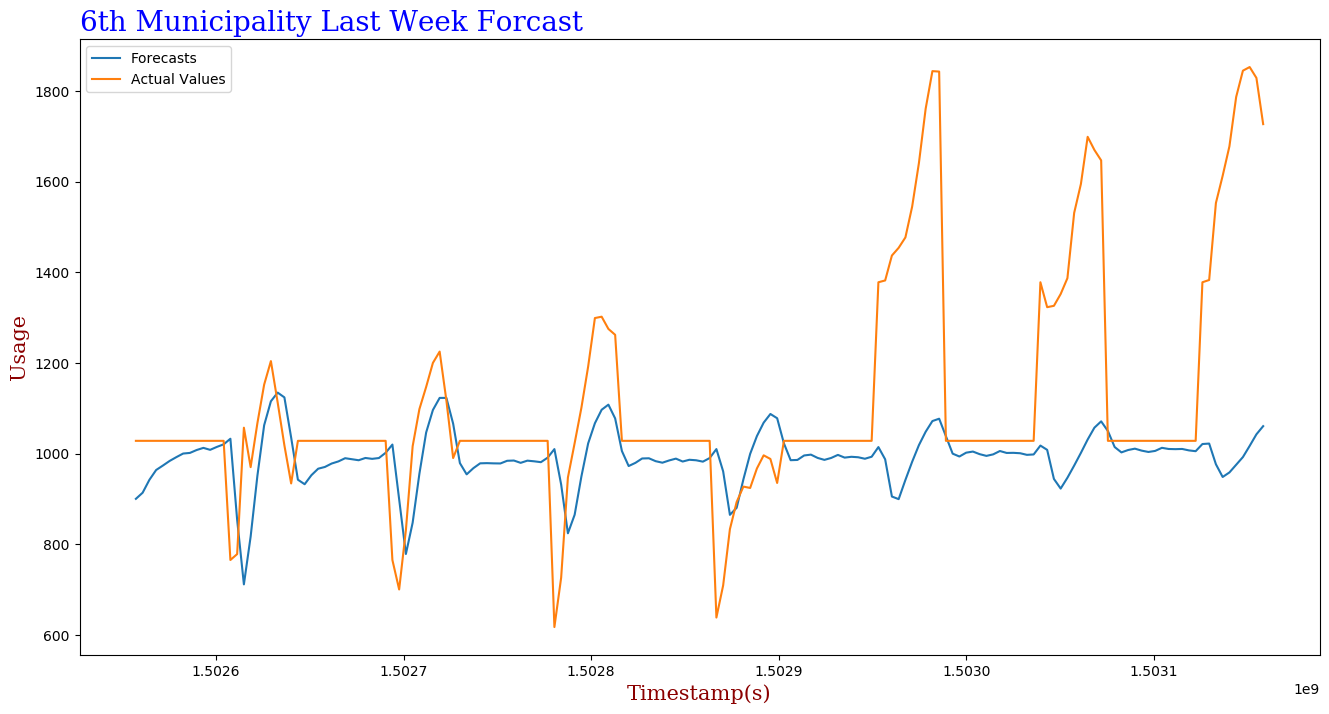

In [28]:
y2 = np.array(modelDf[['Actual Values']])
y1 = np.array(modelDf[['Forecasts']])
x=np.array(modelDf[['Timestamp']])
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.figure(figsize=(16, 8))
plt.title("6th Municipality Last Week Forcast", fontdict = font1, loc = 'left')
plt.xlabel("Timestamp(s)", fontdict = font2)
plt.ylabel("Usage", fontdict = font2)
plt.plot(x,y1,label='Forecasts')
plt.plot(x,y2,label='Actual Values')
plt.legend()
plt.show()